In [1]:
import os
from est_lib.util.obspy_util import *
from est_lib.util.obspy_plot import ray_plot_multi
from est_lib.dataset.seismic_dataset_new import EQDataset, get_device
from obspy import UTCDateTime as dt
from tqdm.notebook import tqdm

In [2]:
import numpy as np
import random

In [3]:
# Torch and NN Imports
import torch
from est_lib.nn.cp_line_simple import cp_line_simple
from torch.utils.tensorboard import SummaryWriter

In [4]:
#RNG
torch.manual_seed(42)
random.seed(0)
np.random.seed(0)

In [5]:
test_name = "test-{}-horizon-20k-new-error".format(str(dt.now()).replace(':','.'))
folder = 'one-off'
writer_path = os.path.join('runs','experiments',folder,test_name)
writer = SummaryWriter(writer_path)

In [6]:
# Save
filepath = os.path.abspath(writer_path)

# Objective

## - Given Seismometer data from station "HOLB" and "PACB", predict the the waveform at "WOSB"

## - ML Model is Trained using Data from Event 1 and Tested using Data from Event 2

# 1. Events and Stations

In [7]:
sta_list = ['HOLB','PACB','WOSB','HOPB']
cha_list = ['HHE','HHN','HHZ']

event1 = ('6.3',50.6081,-129.9656,"2019-12-25T03:36:01.578000Z")
event2 = ('6.0',+50.517,-129.757,"2019-12-23T20:56:23.555000Z")

horizon = 20000

In [8]:
# Inventory
inv = inventory_retriever(network="CN",
                              sta_list=sta_list,
                              level='response')
inv_file = inventory_writer(inv,
                            os.path.join(filepath,'inv.xml'),
                            file_format="STATIONXML")
sb = 600
sa = 1800

# Event 1
ev_1_train_x = stream_retriever(event_time = dt(event1[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list[0:-1],
                          channel_list=cha_list)

ev_1_train_y = stream_retriever(event_time = dt(event1[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list[-1:],
                          channel_list=cha_list)

# Event2
ev_2_test_x = stream_retriever(event_time = dt(event2[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list[0:-1],
                          channel_list=cha_list)

ev_2_test_y = stream_retriever(event_time = dt(event2[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list[-1:],
                          channel_list=cha_list)

In [9]:
# Remove Response
ev_1_train_x.remove_response(inventory=inv)
ev_1_train_y.remove_response(inventory=inv)
ev_2_test_x.remove_response(inventory=inv)
ev_2_test_y.remove_response(inventory=inv)

3 Trace(s) in Stream:
CN.HOPB..HHE | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:16:23.550000Z | 100.0 Hz, 180000 samples
CN.HOPB..HHN | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:16:23.550000Z | 100.0 Hz, 180000 samples
CN.HOPB..HHZ | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:16:23.550000Z | 100.0 Hz, 180000 samples

# Visualize Event Sources and Stations

In [10]:
plot_stream = ev_1_train_x.select()
for t in ev_1_train_y:
    plot_stream.append(t)
plot_stream

12 Trace(s) in Stream:
CN.HOLB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.HOLB..HHN | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.HOLB..HHZ | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.PACB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.PACB..HHN | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.PACB..HHZ | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.WOSB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.WOSB..HHN | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.WOSB..HHZ | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.HOPB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 10

## Event 1 [Blue] (For Training)

- Magintude: 6.3
- Origin: 50.6081,-129.9656
- Time (UTC): 2019-12-25T03:36:01.578000Z

## Event 2 [Red] (For Testing)

- Magintude: 6.0
- Origin: +50.517,-129.757
- Time (UTC): 2019-12-23T20:56:23.555000Z

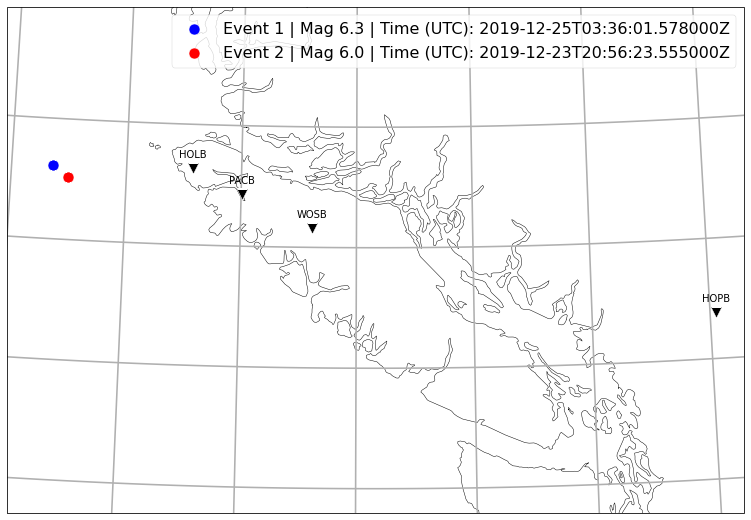

In [11]:
ev_fig = ray_plot_multi(
    ev_lat=[event1[1],event2[1]],
    ev_lon=[event1[2],event2[2]],
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=plot_stream,
    inventory=inv,
    comment=['| Mag {} | Time (UTC): {}'.format(event1[0],event1[3]),
             '| Mag {} | Time (UTC): {}'.format(event2[0],event2[3])])

In [12]:
writer.add_figure('1.Events and Stations',ev_fig,global_step=0)

## Prep Data for NN

In [13]:
# Train Files
train_x_f_path = os.path.join(filepath,'train_x.npy')
train_x_file = stream_data_writer(ev_1_train_x,
                              inv,
                              train_x_f_path,
                              sta_list[0:-1],
                              cha_list)
        
train_y_f_path = os.path.join(filepath,'train_y.npy')
train_y_file = stream_data_writer(ev_1_train_y,
                              inv,
                              train_y_f_path,
                              sta_list[-1:],
                              cha_list)

In [14]:
# Test Files
test_x_f_path = os.path.join(filepath,'test_x.npy')
test_x_file = stream_data_writer(ev_2_test_x,
                              inv,
                              test_x_f_path,
                              sta_list[0:-1],
                              cha_list)
        
test_y_f_path = os.path.join(filepath,'test_y.npy')
test_y_file = stream_data_writer(ev_2_test_y,
                              inv,
                              test_y_f_path,
                              sta_list[-1:],
                              cha_list)

## Generate Train and Test Dataset Objects

In [15]:
# Load Dataset
train_dataset = EQDataset(inv_file,
                    train_x_file,train_y_file,
                    sta_list=sta_list,
                    chan_list=cha_list,
                    ip_dim=len(cha_list),
                    num_nodes=len(sta_list[0:-1]),
                    seq_length=500,horizon=horizon)

test_dataset = EQDataset(inv_file,
                    test_x_file,test_y_file,
                    sta_list=sta_list,
                    chan_list=cha_list,
                    ip_dim=len(cha_list),
                    num_nodes=len(sta_list[-1:]),
                    seq_length=500,horizon=horizon)

In [16]:
# Scale Data
#scale = 1000
#train_dataset.stream_data = train_dataset.stream_data * scale
#test_dataset.stream_data = test_dataset.stream_data * scale

## Batch Data for Quicker Training

In [17]:
# Data Loader
batch_len = 1000
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_len)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_len)

## Initialize Model

In [18]:
# Model
net = cp_line_simple(num_in_nodes=len(sta_list[0:-1]),feat_size=len(cha_list))
net = net.to(get_device())

In [19]:
pre_weights_lstm = list()
for ls in range(len(net.lstms)):
    pre_weights_lstm.append(net.lstms[ls]._parameters)

pre_weights_ff_hidden = list()
for ls in range(len(net.hidden)):
    pre_weights_ff_hidden.append(net.hidden[ls]._parameters)
    
pre_weights_ff_op = list()
for ls in range(len(net.op)):
    pre_weights_ff_op.append(net.op[ls]._parameters)

# 2. Functions and Code for Train/Eval Routine

In [20]:
num_epoch = 21
#optimizer = torch.optim.Adadelta(net.parameters())
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
loss1 = torch.nn.MSELoss(reduction='sum')
loss2 = torch.nn.MSELoss(reduction='sum')
loss3 = torch.nn.MSELoss(reduction='sum')

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Function to Run Inference and Return pred_array and loss
def run_inference(model,test_data_loader,gen_prediction=False):
    if gen_prediction:
        pred = list()
    model.eval()
    test_losses = torch.zeros(1) # to accumulate losses
    for b,b_input in tqdm(enumerate(test_data_loader)):
        with torch.no_grad():
            x = b_input[0]
            y = b_input[1]
            # Forward Pass
            op = net(x)
            if gen_prediction:
                pred.append(op)
            # Loss
            lx = loss1(op[0],y[:,:,0])
            t_loss = lx
            if len(op) > 1:
                ly = loss1(op[1],y[:,:,1])
                t_loss += ly
            if len(op) > 2:
                lz = loss1(op[2],y[:,:,2])
                t_loss += lz
            test_losses+=t_loss.to('cpu')
    total_loss = test_losses / (b+1)
    if gen_prediction:
        return pred,total_loss
    else:
        return total_loss

# Function to Transform Inference Output into Timeseries Numpy Array
def write_op_to_numpy_streams(obj,features,seq_len):
    res = list()
    for i,op in tqdm(enumerate(obj)):
        if i==0:
            tempx = np.concatenate((np.zeros([seq_len,1]),op[0].detach().cpu().numpy()))
            if features > 1:
                tempy = np.concatenate((np.zeros([seq_len,1]),op[1].detach().cpu().numpy()))
            if features > 2:
                tempz = np.concatenate((np.zeros([seq_len,1]),op[2].detach().cpu().numpy()))
        else:
            tempx = np.concatenate((tempx,op[0].detach().cpu().numpy()))
            if features > 1:
                tempy = np.concatenate((tempy,op[1].detach().cpu().numpy()))
            if features > 2:
                tempz = np.concatenate((tempz,op[2].detach().cpu().numpy()))
    res.append(tempx)
    if features > 1:
        res.append(tempy)
    if features > 2:
        res.append(tempz)
    return res

# Function to Plot Ground Truth vs Prediction
def gen_plots(pred_data,real_data,station,comment='',scale=1):
    fig = plt.figure(figsize=(15,15))
    title_strings = ['East-West','North-South','Up-Down']
    for sp in range(len(pred_data)):
        ax = fig.add_subplot(3,1,sp+1)
        ax.plot((real_data[sp].data)*scale,label='Ground Truth')
        ax.plot(pred_data[sp],label='Predicted')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Ground Velocity (m/s)')
        ax.set_title('Station: {}, Direction: {} {}'.format(station,title_strings[sp],comment))
        plt.grid()
        plt.legend()
    fig.tight_layout()
    plt.show()
    return fig

## Before Training, Visualize Output from Untrained Model on Test Data (Event 2)

In [23]:
pre_pred,pre_tst_loss = run_inference(net,test_loader,gen_prediction=True)
print("Pre Trained Model, Loss on Test Set = {}".format(pre_tst_loss))

0it [00:00, ?it/s]

Pre Trained Model, Loss on Test Set = tensor([406.5318])


In [24]:
writer.add_scalar('Test Loss - Untrained',pre_tst_loss,0)

In [25]:
pre_inference_op = write_op_to_numpy_streams(pre_pred,test_dataset.ip_dim,test_dataset.seq_length)

0it [00:00, ?it/s]

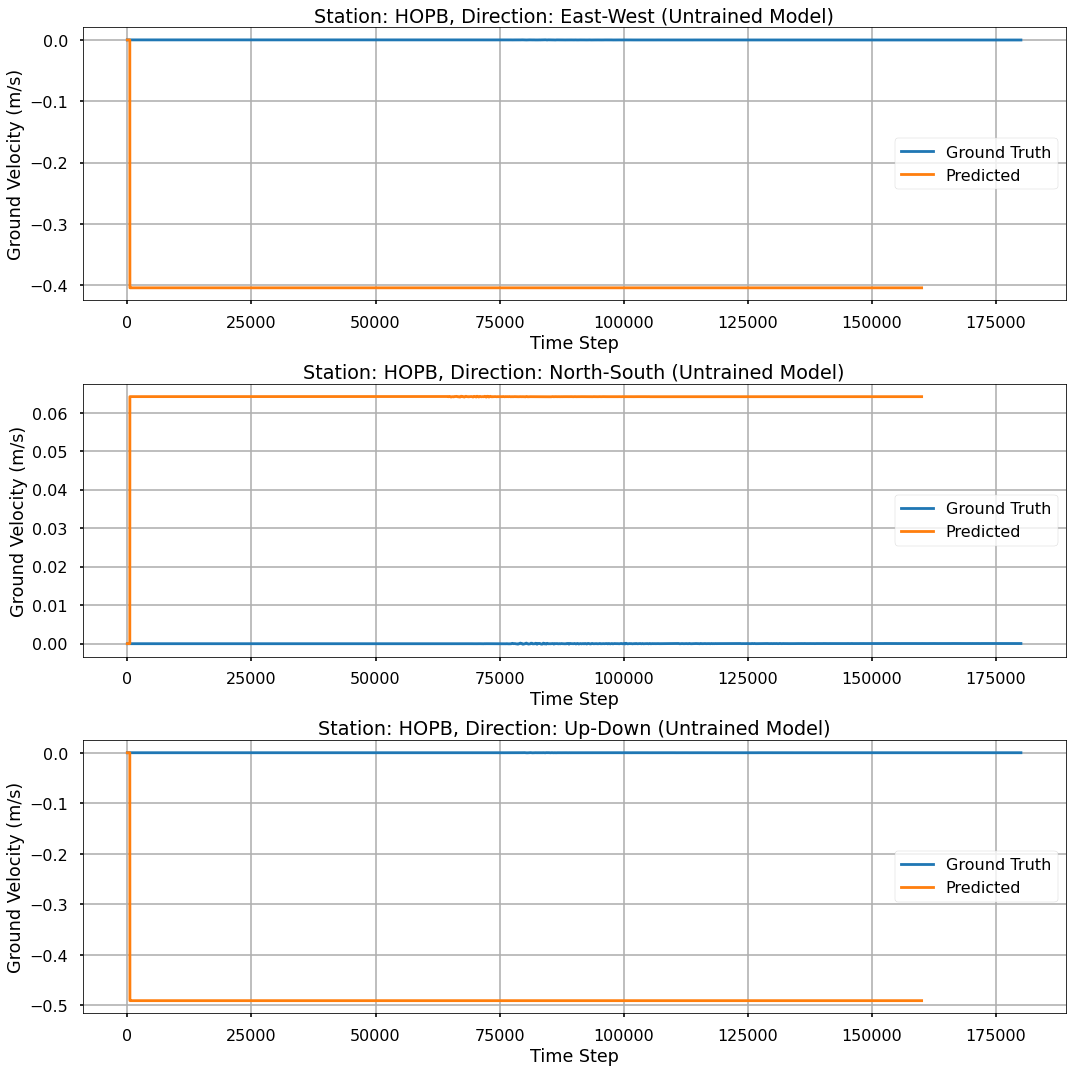

In [26]:
# Plot
fig_inference_trained = gen_plots(pre_inference_op,ev_2_test_y,sta_list[-1],comment='(Untrained Model)')

In [27]:
writer.add_figure('2. Untrained Model Prediction at WOSB',fig_inference_trained,global_step=0)

# Training Loop (Trains Model on Data from Event 1)

In [28]:
gen = net.parameters()
for it in gen:
    print(it)

Parameter containing:
tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165],
        [-0.2811,  0.3391,  0.5090],
        [-0.4236,  0.5018,  0.1081],
        [ 0.4266,  0.0782,  0.2784],
        [-0.0815,  0.4451,  0.0853],
        [-0.2695,  0.1472, -0.2660],
        [-0.0677, -0.2345,  0.3830],
        [-0.4557, -0.2662, -0.1630],
        [-0.3471,  0.0545, -0.5702],
        [ 0.5214, -0.4904,  0.4457],
        [ 0.0961, -0.1875,  0.3568]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0900,  0.4665,  0.0631],
        [-0.1821,  0.1551, -0.1566],
        [ 0.2430,  0.5155,  0.3337],
        [-0.2524,  0.3333,  0.1033],
        [ 0.2932, -0.3519, -0.5715],
        [-0.2231, -0.4428,  0.4737],
        [ 0.1663,  0.2391,  0.1826],
        [-0.0100,  0.4518, -0.4102],
        [ 0.0364, -0.3941,  0.1780],
        [-0.1988,  0.1769, -0.1203],
        [ 0.4788, -0.3422, -0.3443],
        [-0.3444,  0.5193,  0.1924]], device='cuda:0', requires_gra

In [29]:
#tr_loss.grad

In [30]:
# Train Loop
for e in tqdm(range(num_epoch)):
    net.train()
    run_loss_train = torch.zeros(1)
    run_loss_test = torch.zeros(1)
    for i,batch in tqdm(enumerate(train_loader)):
        net.zero_grad()
        x = batch[0]
        y = batch[1]
        # Forward Pass
        op = net(x)
        if e==0 and i==0:
            writer.add_graph(net,x)
        # Loss Scaling
        scale = list()
        for lnum in range(len(op)):
            pred = max(y[:,:,lnum])
            if abs(pred) > 0.0001:
                scale.append(100)
            else:
                scale.append(1)
        # Loss
        lx = loss1(op[0]*scale[0],y[:,:,0]*scale[0])
        tr_loss = lx
        if len(op) > 1:
            ly = loss1(op[1]*scale[1],y[:,:,1]*scale[1])
            tr_loss += ly
        if len(op) > 2:
            lz = loss1(op[2]*scale[2],y[:,:,2]*scale[2])
            tr_loss += lz
        run_loss_train+=tr_loss.to('cpu')
        tr_loss.backward()
        optimizer.step()
    writer.add_scalar('Train Loss',run_loss_train/(i+1),e)
    # One Test Loop
    t_loss = run_inference(net,test_loader)
    writer.add_scalar('Test Loss',t_loss.to('cpu')/(i+1),e)

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

D:\Development\Anaconda\envs\torch-spatio-temporal\lib\site-packages\torch\jit\_trace.py:934: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [31]:
# Save Model Checkpoint
epo = e
f_name = "model.pt"
f_path = os.path.join(writer_path,f_name)
lo = tr_loss

torch.save({
            'epoch': epo,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lo,
            }, f_path)

# 3. Run Inference on Trained Model

## Run Inference on Test Set and Plot Predictions vs Ground Truth

In [32]:
new_pred,tst_loss = run_inference(net,test_loader,gen_prediction=True)
print("Loss = {}".format(tst_loss))

0it [00:00, ?it/s]

Loss = tensor([1.3046e-05])


In [33]:
writer.add_scalar('Test Loss - Trained',tst_loss,0)

In [34]:
inference_op = write_op_to_numpy_streams(new_pred,test_dataset.ip_dim,test_dataset.seq_length)

0it [00:00, ?it/s]

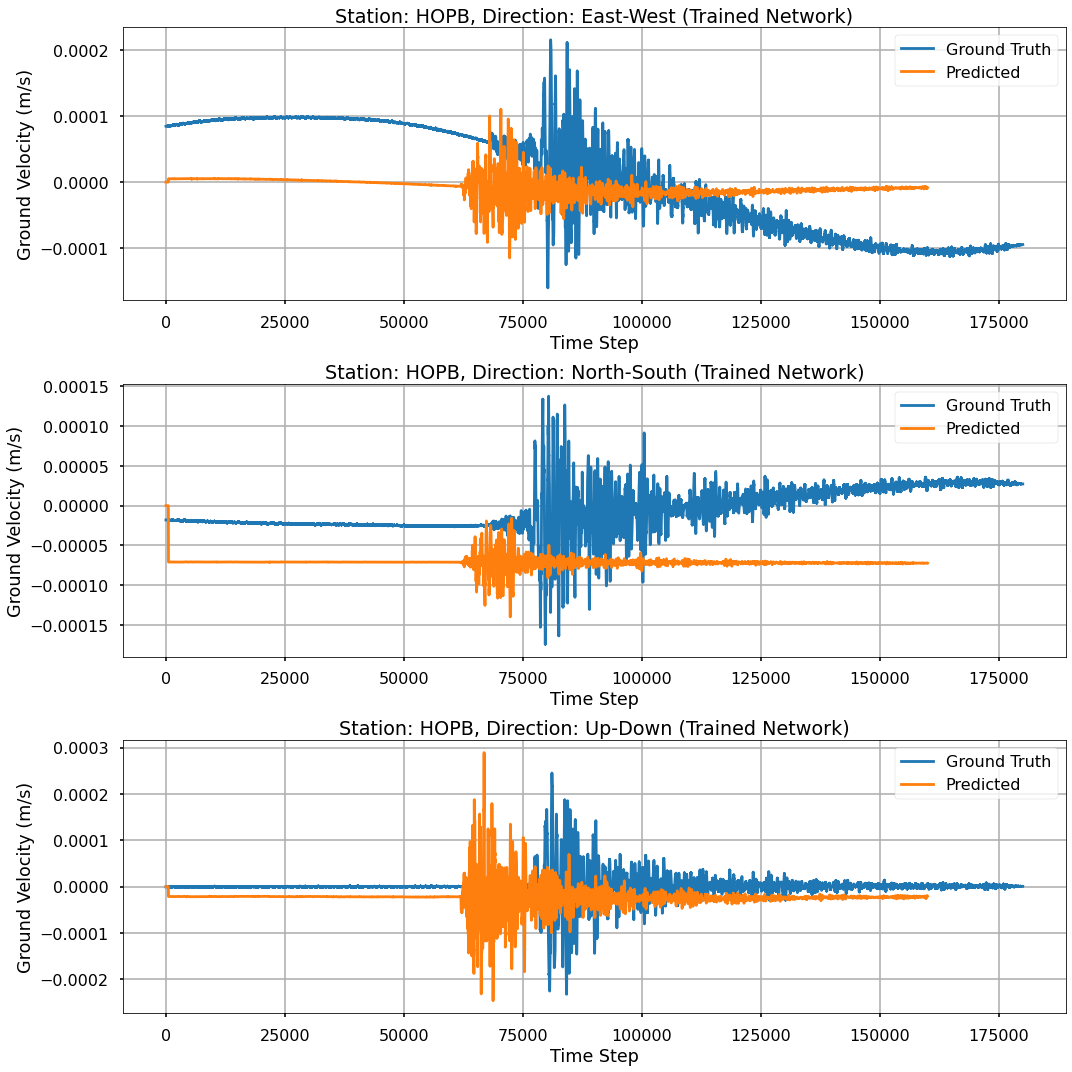

In [35]:
# Plot
fig_inference_trained = gen_plots(inference_op,ev_2_test_y,sta_list[-1],comment='(Trained Network)')

# Train Set OP

0it [00:00, ?it/s]

0it [00:00, ?it/s]

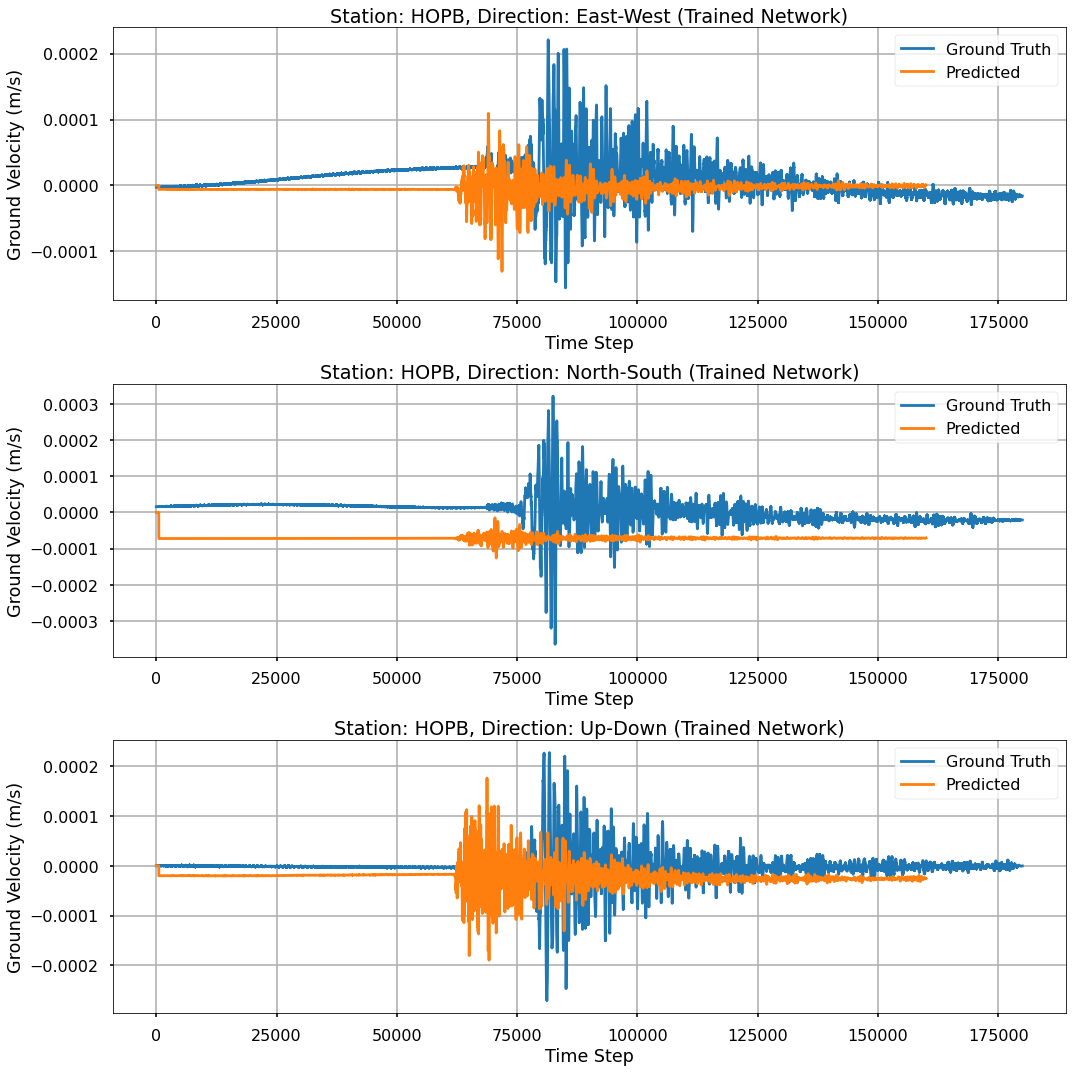

In [36]:
# Train Output
new_pred_train,trn_loss = run_inference(net,train_loader,gen_prediction=True)
inference_op_trn = write_op_to_numpy_streams(new_pred_train,train_dataset.ip_dim,train_dataset.seq_length)
fig_inference_trained = gen_plots(inference_op_trn,ev_1_train_y,sta_list[-1],comment='(Trained Network)')

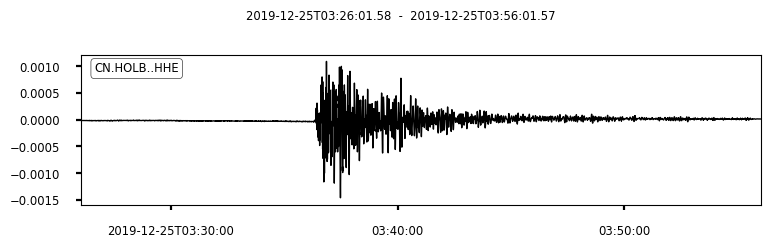

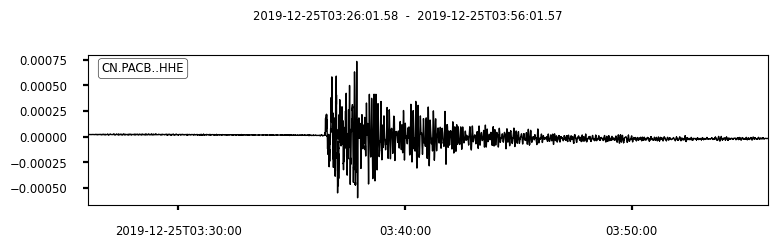

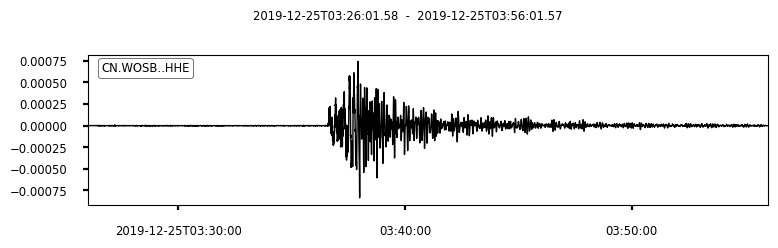

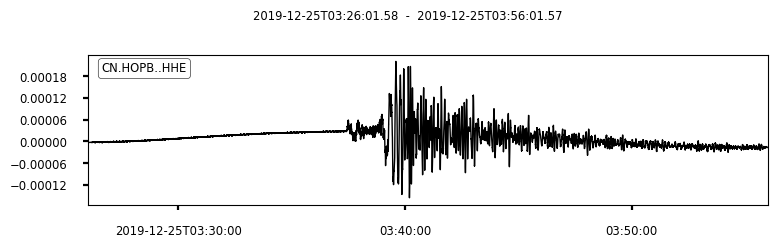

In [37]:
op = ev_1_train_x[0].plot()
op = ev_1_train_x[3].plot()
op = ev_1_train_x[6].plot()
op = ev_1_train_y[0].plot()

In [38]:
writer.add_figure('3. Trained Model Prediction at WOSB',fig_inference_trained,global_step=e)
writer.flush()
writer.close()

In [39]:
post_weights_lstm = list()
for ls in range(len(net.lstms)):
    post_weights_lstm.append(net.lstms[ls]._parameters)

post_weights_ff_hidden = list()
for ls in range(len(net.hidden)):
    post_weights_ff_hidden.append(net.hidden[ls]._parameters)

post_weights_ff_op = list()
for ls in range(len(net.op)):
    post_weights_ff_op.append(net.op[ls]._parameters)

# LSTMS

In [40]:
pre_weights_lstm

[OrderedDict([('weight_ih_l0',
               Parameter containing:
               tensor([[ 5.1453e-01,  4.3865e-01, -8.2322e-02],
                       [ 6.0488e-01, -1.6808e-01,  1.7267e-01],
                       [-3.6696e-01,  3.8728e-01,  4.2470e-01],
                       [-3.5213e-01,  4.6192e-01,  1.6004e-01],
                       [ 4.9965e-01,  3.7144e-02,  3.3363e-01],
                       [-1.6647e-01,  4.9321e-01, -1.5258e-04],
                       [-1.9385e-01,  1.0554e-01, -2.1156e-01],
                       [ 1.1460e-02, -2.7326e-01,  4.3758e-01],
                       [-5.3658e-01, -2.2213e-01, -2.3431e-01],
                       [-2.7488e-01,  1.4254e-02, -5.1781e-01],
                       [ 5.9606e-01, -5.3207e-01,  5.0198e-01],
                       [ 1.1986e-02, -1.3961e-01,  2.7175e-01]], device='cuda:0',
                      requires_grad=True)),
              ('weight_hh_l0',
               Parameter containing:
               tensor([[ 0.0216,  

In [41]:
post_weights_lstm

[OrderedDict([('weight_ih_l0',
               Parameter containing:
               tensor([[ 5.1453e-01,  4.3865e-01, -8.2322e-02],
                       [ 6.0488e-01, -1.6808e-01,  1.7267e-01],
                       [-3.6696e-01,  3.8728e-01,  4.2470e-01],
                       [-3.5213e-01,  4.6192e-01,  1.6004e-01],
                       [ 4.9965e-01,  3.7144e-02,  3.3363e-01],
                       [-1.6647e-01,  4.9321e-01, -1.5258e-04],
                       [-1.9385e-01,  1.0554e-01, -2.1156e-01],
                       [ 1.1460e-02, -2.7326e-01,  4.3758e-01],
                       [-5.3658e-01, -2.2213e-01, -2.3431e-01],
                       [-2.7488e-01,  1.4254e-02, -5.1781e-01],
                       [ 5.9606e-01, -5.3207e-01,  5.0198e-01],
                       [ 1.1986e-02, -1.3961e-01,  2.7175e-01]], device='cuda:0',
                      requires_grad=True)),
              ('weight_hh_l0',
               Parameter containing:
               tensor([[ 0.0216,  

# FF Hidden

In [42]:
pre_weights_ff_hidden

[OrderedDict([('weight',
               Parameter containing:
               tensor([[ 0.4057, -0.1611, -0.1529],
                       [-0.3146, -0.5926, -0.6497],
                       [ 0.1352, -0.3883, -0.4593]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([-0.1260, -0.2740, -0.2688], device='cuda:0', requires_grad=True))]),
 OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.0139, -0.1225, -0.2054],
                       [-0.3102, -0.4678,  0.4797],
                       [-0.2015,  0.1572, -0.1896]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([0.0517, 0.5408, 0.2571], device='cuda:0', requires_grad=True))]),
 OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.6220,  0.3337,  0.4857],
                       [ 0.0309,  0.4906,  0.5075],
                 

In [43]:
post_weights_ff_hidden

[OrderedDict([('weight',
               Parameter containing:
               tensor([[ 0.4057, -0.1611, -0.1529],
                       [-0.3146, -0.5926, -0.6497],
                       [ 0.1352, -0.3883, -0.4593]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([-0.1260, -0.2740, -0.2688], device='cuda:0', requires_grad=True))]),
 OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.0139, -0.1225, -0.2054],
                       [-0.3102, -0.4678,  0.4797],
                       [-0.2015,  0.1572, -0.1896]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([0.0517, 0.5408, 0.2571], device='cuda:0', requires_grad=True))]),
 OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.6220,  0.3337,  0.4857],
                       [ 0.0309,  0.4906,  0.5075],
                 

# FF OP

In [44]:
pre_weights_ff_op

[OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.4014, -0.5473, -0.4802]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([-0.4884], device='cuda:0', requires_grad=True))]),
 OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.4384, -0.1456,  0.3706]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([0.0899], device='cuda:0', requires_grad=True))]),
 OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.5492, -0.3703,  0.3901]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([-0.3306], device='cuda:0', requires_grad=True))])]

In [45]:
post_weights_ff_op

[OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.4014, -0.5473, -0.4802]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([-0.4884], device='cuda:0', requires_grad=True))]),
 OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.4384, -0.1456,  0.3706]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([0.0899], device='cuda:0', requires_grad=True))]),
 OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.5492, -0.3703,  0.3901]], device='cuda:0', requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([-0.3306], device='cuda:0', requires_grad=True))])]

In [46]:
gen = net.parameters()
for it in gen:
    print(it)

Parameter containing:
tensor([[ 5.1453e-01,  4.3865e-01, -8.2322e-02],
        [ 6.0488e-01, -1.6808e-01,  1.7267e-01],
        [-3.6696e-01,  3.8728e-01,  4.2470e-01],
        [-3.5213e-01,  4.6192e-01,  1.6004e-01],
        [ 4.9965e-01,  3.7144e-02,  3.3363e-01],
        [-1.6647e-01,  4.9321e-01, -1.5258e-04],
        [-1.9385e-01,  1.0554e-01, -2.1156e-01],
        [ 1.1460e-02, -2.7326e-01,  4.3758e-01],
        [-5.3658e-01, -2.2213e-01, -2.3431e-01],
        [-2.7488e-01,  1.4254e-02, -5.1781e-01],
        [ 5.9606e-01, -5.3207e-01,  5.0198e-01],
        [ 1.1986e-02, -1.3961e-01,  2.7175e-01]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[ 0.0216,  0.4000, -0.0244],
        [-0.2622,  0.0807, -0.2611],
        [ 0.3613,  0.6235,  0.4702],
        [-0.3198,  0.2678,  0.0161],
        [ 0.2147, -0.4250, -0.6743],
        [-0.1031, -0.3333,  0.6114],
        [ 0.0968,  0.1708,  0.0958],
        [-0.1002,  0.3689, -0.5265],
        [ 0.1378, -0.3025, 

In [47]:
from torchviz import make_dot

In [48]:
make_dot(op)

AttributeError: 'Figure' object has no attribute 'size'